
   #  Spatial Declustering in Python for Engineers and Geoscientists 

## with GSLIB's DECLUS Program Converted to Python

### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **spatial declustering in Python with GSLIB's DECLUS program translated to Python, wrappers and reimplementations of other GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). Almost every spatial dataset is based on biased sampling.  This includes clustering (increased density of samples) over specific ranges of values.  For example, more samples in an area of high feature values.  Spatial declustering is a process of assigning data weights based on local data density.  The cell-based declustering approach (Deutsch and Journel, 1997; Pyrcz and Deutsch, 2014; Pyrcz and Deutsch, 2003, paper is available here: http://gaa.org.au/pdf/DeclusterDebias-CCG.pdf) is based on the use of a mesh over the area of interest.  Each datum's weight is inverse to the number of data in each cell.  Cell offsets of applied to smooth out influence of mesh origin.  Multiple cell sizes are applied and typically the cell size that minimizes the declustered distribution mean is applied for preferential sampling in the high-valued locations (the maximizing cell size is applied if the data is preferential sampled in the low-valued locations).  If there is a nominal data spacing with local clusters, then this spacing is the best cell size.

This exercise demonstrates the cell-based declustering approach in Python with wrappers and reimplimentation of GSLIB methods.  The steps include:

1. generate a 2D sequential Guassian simulation using a wrapper of GSLIB's sgsim method
2. apply regular sampling to the 2D realization
3. preferentially removing samples in the low-valued locations
4. calculate cell-based declustering weights with the **declus function**
5. visualize the location map of the declustering weights and the original exhaustive, sample and the new declustered distribution along with the scatter plot of declustered weight vs. cell size.

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

These methods are all in the functions declared upfront. To run this demo all one has to do is download and place in your working directory the following executables from the GSLIB/bin directory:

1. sgsim.exe
2. nscore.exe (not currently used in demo, but wrapper is included)

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

This was my first effort to translate the GSLIB Fortran to Python.  It was pretty easy so I'll start translating other critical GSLIB functions.

#### Load the required libraries

The following code loads the required libraries.

In [ ]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.

In [86]:
# Some GeostatsPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7.
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    print(str(step))
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var
    
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

Here's the translation of declus to Python (Michael Pyrcz, Jan. 2019 - let me know if you find any issues).

In [154]:
import numpy as np
import pandas as pd

# GSLIB's DECLUS program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)
# note this was simplified to 2D only
def declus(df,xcol,ycol,vcol,iminmax,noff,ncell,cmin,cmax):
# Parameters - consistent with original GSLIB    
# df - Pandas DataFrame with the spatial data
# xcol, ycol - name of the x and y coordinate columns
# vcol - name of the property column
# iminmax - 1 / True for use cell size with max decluster mean, 0 / False for declustered mean minimizing cell size
# noff - number of offsets
# ncell - number of cell sizes
# cmin, cmax - min and max cell size
#
# Load Data and Set Up Arrays
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    v = df[vcol].values
    wt = np.zeros(nd)
    wtopt = np.ones(nd)
    index = np.zeros(nd, np.int32)
    xcs_mat = np.zeros(ncell+2) # we use 1,...,n for this array
    vrcr_mat = np.zeros(ncell+2) # we use 1,...,n for this array
    anisy = 1.0   # hard code the cells to 2D isotropic
    roff = float(noff)
    
# Calculate extents    
    xmin = np.min(x); xmax = np.max(x)
    ymin = np.min(y); ymax = np.max(y)
      
# Calculate summary statistics
    vmean = np.mean(v)
    vstdev = np.std(v)
    vmin = np.min(v)
    vmax = np.max(v)
    xcs_mat[0] = 0.0; vrcr_mat[0] = vmean; vrop = vmean # include the naive case
    print('There are ' + str(nd) + ' data with:')
    print('   mean of      ' + str(vmean) + ' ')
    print('   min and max  ' + str(vmin) + ' and ' + str(vmax))
    print('   standard dev ' + str(vstdev) + ' ')
    
# define a "lower" origin to use for the cell sizes:
    xo1 = xmin - 0.01
    yo1 = ymin - 0.01

# define the increment for the cell size:
    xinc = (cmax-cmin) / ncell
    yinc = xinc

# loop over "ncell+1" cell sizes in the grid network:
    ncellx = int((xmax-(xo1-cmin))/cmin)+1
    ncelly = int((ymax-(yo1-cmin*anisy))/(cmin))+1
    ncellt = ncellx*ncelly 
    cellwt = np.zeros(ncellt)
    xcs =  cmin - xinc
    ycs = (cmin*anisy) - yinc

# MAIN LOOP over cell sizes:
    for lp in range(1,ncell+2):   # 0 index is the 0.0 cell, note n + 1 in Fortran
        xcs = xcs + xinc
        ycs = ycs + yinc
        
# initialize the weights to zero: 
        wt.fill(0.0)

# determine the maximum number of grid cells in the network:
        ncellx = int((xmax-(xo1-xcs))/xcs)+1
        ncelly = int((ymax-(yo1-ycs))/ycs)+1
        ncellt = float(ncellx*ncelly)

# loop over all the origin offsets selected:
        xfac = min((xcs/roff),(0.5*(xmax-xmin)))
        yfac = min((ycs/roff),(0.5*(ymax-ymin)))
        for kp in range(1,noff+1):
            xo = xo1 - (float(kp)-1.0)*xfac
            yo = yo1 - (float(kp)-1.0)*yfac

# initialize the cumulative weight indicators:
            cellwt.fill(0.0)
    
# determine which cell each datum is in:
            for i in range(0,nd):
                icellx = int((x[i] - xo)/xcs) + 1
                icelly = int((y[i] - yo)/ycs) + 1
                icell  = icellx + (icelly-1)*ncellx  
                index[i] = icell
                cellwt[icell] = cellwt[icell] + 1.0


# The weight assigned to each datum is inversely proportional to the
# number of data in the cell.  We first need to get the sum of weights
# so that we can normalize the weights to sum to one:
            sumw = 0.0
            for i in range(0,nd):
                ipoint = index[i]
                sumw   = sumw + (1.0 / cellwt[ipoint])
            sumw = 1.0 / sumw
                
# Accumulate the array of weights (that now sum to one):
            for i in range(0,nd):
                ipoint = index[i]
                wt[i] = wt[i] + (1.0/cellwt[ipoint])*sumw

# End loop over all offsets:

# compute the weighted average for this cell size:
        sumw  = 0.0
        sumwg = 0.0
        for i in range(0,nd):
            sumw  = sumw + wt[i]
            sumwg = sumwg + wt[i]*v[i]
        vrcr = sumwg / sumw
        vrcr_mat[lp] = vrcr
        xcs_mat[lp] = xcs

# see if this weighting is optimal:
        if iminmax and vrcr < vrop or not iminmax and vrcr > vrop or ncell == 1:
            best = xcs
            vrop = vrcr
            wtopt = wt.copy()   # deep copy

# END MAIN LOOP over all cell sizes:

# Get the optimal weights:
    sumw = 0.0
    for i in range(0,nd):
        sumw = sumw + wtopt[i]
    wtmin = np.min(wtopt)
    wtmax = np.max(wtopt)
    facto = float(nd) / sumw
    wtopt = wtopt * facto
    return wtopt,xcs_mat,vrcr_mat

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.


In [155]:
os.chdir("c:/PGE337/DataAnalysis")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a 2D spatial model

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction to ensure we have a reasonable mean and spread for our feature's distribution, assumed to be Porosity (e.g. no negative values) while retaining the Gaussian distribution.  Any transform could be applied at this point.  We are keeping this workflow simple. *This is our truth model that we will sample*.

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

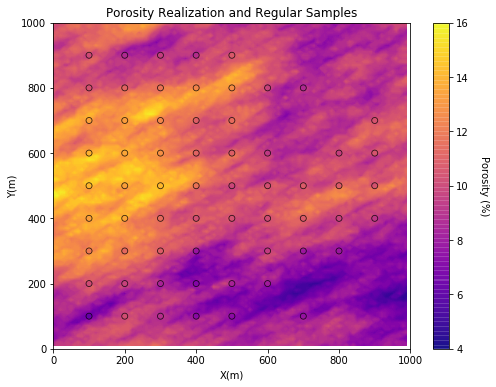

In [156]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74073                                                     # random number seed  for stochastic simulation    
range_max = 1800; range_min = 500; azimuth = 65                  # Porosity variogram ranges and azimuth
vario = make_variogram(0.0,nst=1,it1=1,cc1=1.0,azi1=65,hmaj1=1800,hmin1=500)
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,vario,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
sampling_ncell = 10                                              # sample every 10th node from the model
samples = regular_sample(sim,xmin,xmax,ymin,ymax,sampling_ncell,10,10,'Realization')
samples_cluster = samples.drop([80,79,78,73,72,71,70,65,64,63,61,57,56,54,53,47,45,42]) # this removes specific rows (samples)
samples_cluster = samples_cluster.reset_index(drop=True)         # we reset and remove the index (it is not sequential anymore)
locpix(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples_cluster,'X','Y','Realization','Porosity Realization and Regular Samples','X(m)','Y(m)','Porosity (%)',cmap,"Por_Samples")

Let's compare the distribution and means of the truth model and the spatially clustered samples.  We do this with the hist function that is reimplemented from GSLIB's hist method for histogram plotting.  The parameters of hist are (array,xmin,xmax,log,cumul,bins,weights,xlabel,title), including array, xmin and xmax the data array and minimum and maximum of the feature, log and cumul with true for log axis and cumulative distribution function, bins for the number of bins, weights for an array of same size of the data array with weights and the remainder are labels.

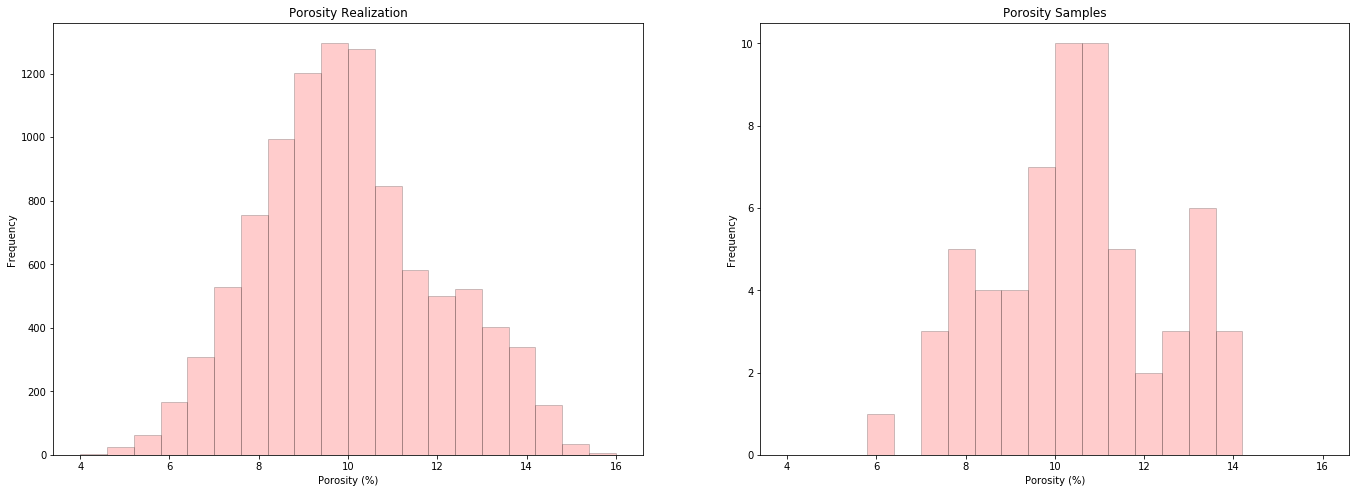

Truth Mean =  10.0 , Clustered Sample Mean =  10.49 , Error =  4.9 %


In [157]:
plt.subplot(121)
hist_st(sim.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Realization")
plt.subplot(122)
hist_st(samples_cluster["Realization"],vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Samples")
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

sm_mean = np.average(samples_cluster['Realization'])
ex_mean = np.average(sim)
print('Truth Mean = ',round(ex_mean,2),', Clustered Sample Mean = ',round(sm_mean,2),', Error = ',round((sm_mean-ex_mean)/ex_mean,3)*100,'%')

Note the shift in mean from the truth model to the clustered sample. There is a 4.8% inflation in the clustered sample mean! This will be a good demonstration clustered data set for the value of cell-based declustering. We have created a biased sample set with spatial clustering.  Now we can try some declustering. 

Let's apply the Python translation of **declus**, the GSLIB cell-based declustering program, to this sample set.  The declus method has the following parameters (df,xcol,ycol,vcol,cmin,cmax,cnum,bmin) where df, xcol, ycol, vcol are the DataFrame with the data and the columns with x, y and feature, cmin and cmax are the minimum and maximum cell sizes, cnum is the number of cell sizes (discretization of this range) and bmin is true for selecting the cell size that minimizes the declustered mean (set to false for the cell that maximizes the declustered mean).  

The output from the declus function is a 1D numpy array of weigths with the same size and order as the input DataFrame for the optmum cell size and also the cell sizes and declustered average for each cell size (that's 3 1D ndarrays).  After we calculate the weights numpy array we convert it to a DataFrame and append it (concat) it to our sample DataFrame.  Then we visualize the histogram and location map of the weights.  We will take a wide range of cell sizes from 1m to 2,000m going from much smaller than the minimum data spacing to twice the model extent.

In [147]:
wts,cell_sizes,averages = declus(samples_cluster,'X','Y','Realization',iminmax=1,noff=5,ncell=100,cmin=1,cmax=2000)

There are 63 data with:
   mean of      10.490800374424563 
   min and max  6.123025768159604 and 14.16801426820596
   standard dev 1.8904816314625261 


Let's visualize the declustered output.  We should check out the porosity distribution naive and declustered, the distribution and location map of the delucstered weights and the plot of cell size vs. declustered mean.

DescribeResult(nobs=63, minmax=(0.5025080128205127, 3.360489510489511), mean=0.9999999999999998, variance=0.3499002180795838, skewness=2.0763024101409284, kurtosis=4.037715196963079)


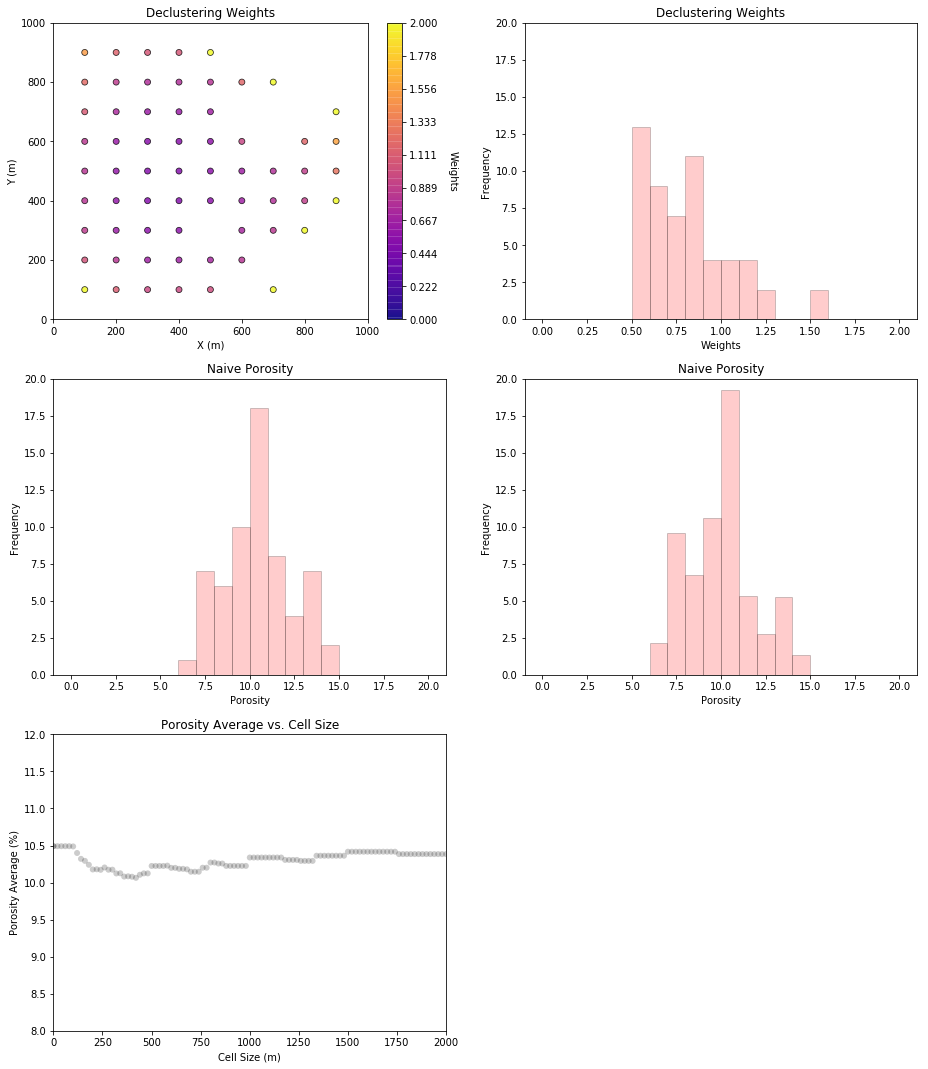

In [159]:
import scipy.stats

samples_cluster['wts'] = wts            # add the weights to the sample data
samples_cluster.head()

plt.subplot(321)
locmap_st(samples_cluster,'X','Y','wts',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(322)
hist_st(samples_cluster['wts'],0.0,2.0,log=False,cumul=False,bins=20,weights=None,xlabel="Weights",title="Declustering Weights")
plt.ylim(0.0,20)

plt.subplot(323)
hist_st(samples_cluster['Realization'],0.0,20.0,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.ylim(0.0,20)

plt.subplot(324)
hist_st(samples_cluster['Realization'],0.0,20.0,log=False,cumul=False,bins=20,weights=samples_cluster['wts'],xlabel="Porosity",title="Declustered Porosity")
plt.ylim(0.0,20)

plt.subplot(325)
plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
plt.xlabel('Cell Size (m)')
plt.ylabel('Porosity Average (%)')
plt.title('Porosity Average vs. Cell Size')
plt.ylim(8,12)
plt.xlim(0,2000)

print(scipy.stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()


There are so many more exercised and tests that one could attempt to gain experience with decison trees. I'll end here for brevity, but I invite you to continue. Consider, on your own apply other data sets or attempting modeling with random forest and boosting.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

**Michael Pyrcz**, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On Twitter I'm the **GeostatsGuy** and on YouTube my lectures are on the channel, **GeostatsGuy Lectures**.